In [47]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import timedelta, datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import cartopy as ctp

from typhon.plots import worldmap, styles, get_cfeatures_at_scale, profile_p
from typhon.files import FileSet
from typhon.collocations import Collocator, expand
from typhon.physics import vmr2relative_humidity, mixing_ratio2vmr, relative_humidity2vmr
plt.style.use(styles.get('typhon'))

In [28]:
iasi_fs = FileSet(path="/scratch/uni/u237/user_data/mprange/iasi_eumetsat_retrieval_data/1378562-2of3/"
                  "*"
                  "{year}{month}{day}{hour}{minute}{second}_*_eps_o_l2.nc")
data_list = iasi_fs.collect("2020-01-24", "2020-01-25")

In [79]:
def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

def plot_wv_map(data_list, plevel):
    fig = plt.figure(figsize=(16,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for data in data_list:
        p_ind = find_nearest(data['pressure_levels_humidity'], plevel * 100.)
        wv = get_domain_array(data, 'atmospheric_water_vapor')
        wv_vmr = mixing_ratio2vmr(wv)
        T = get_domain_array(data, 'atmospheric_temperature')
        P = data['pressure_levels_humidity'].values
        RH = vmr2relative_humidity(wv_vmr, P, T) * 100.
        scat = worldmap(
            data["lat"], data["lon"], RH[:,:,p_ind], 
            draw_coastlines=False, cmap='density', ax=ax, draw_grid=True, 
#             vmin=2.0e-6, vmax=4.0e-6,
                       )
        ax.coastlines(resolution='50m')
        s = f"{np.round(data['pressure_levels_humidity'][p_ind].values / 100., 0)}"
        plt.title(f"p = {s} hPa", y=1.1)
    plt.colorbar(scat, fraction=0.015, label='Relative Humidity [%]')
    ax.set_extent([-75, -40, 0, 25], crs=ccrs.PlateCarree())
    
    
def plot_temp_map(data_list, plevel):
    fig = plt.figure(figsize=(16,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for data in data_list:
        p_ind = find_nearest(data['pressure_levels_humidity'], plevel * 100.)
        T = get_domain_array(data, 'atmospheric_temperature')
        scat = worldmap(
            data["lat"], data["lon"], T[:,:,p_ind], 
            draw_coastlines=False, cmap='temperature', ax=ax, draw_grid=True, 
#             vmin=2.0e-6, vmax=4.0e-6,
                       )
        ax.coastlines(resolution='50m')
        s = f"{np.round(data['pressure_levels_humidity'][p_ind].values / 100., 0)}"
        plt.title(f"p = {s} hPa", y=1.1)
    plt.colorbar(scat, fraction=0.015, label='Temperature [K]')
    ax.set_extent([-75, -40, 0, 25], crs=ccrs.PlateCarree())
    
    
def get_domain_array(data, var_name):
    return data[var_name].where(
        (data.lat > 6.) & (data.lat < 24.) & 
        (data.lon > -90.) & (data.lon < -10.)).values


def collocate_iasi_with_dropsondes(iasi_data, dropsonde_data, collocation_radius, max_interval, 
                                  profiles_available=False):
    iasi_collocation_ds = prepare_iasi_ds_for_collocation(iasi_data)
    dropsonde_collocation_ds = prepare_dropsonde_ds_for_collocation(dropsonde_data)
    collocater = Collocator(threads=4, name='eurec4a_loc_iasi')
    print("Collocating...")
    collocations = collocater.collocate(
        primary=('dropsondes', dropsonde_collocation_ds), 
        secondary=('iasi', iasi_collocation_ds),
        max_distance=collocation_radius, 
        max_interval=max_interval
    )
    collocations = expand(collocations)
    if profiles_available:
        p_ind = find_nearest(collocations['iasi/pressure_levels_humidity'].values, 500.)
        collocations = collocations.isel({
            'collocation': ~np.isnan(collocations['iasi/atmospheric_water_vapor'][p_ind,:]).values,
        }
        )
    return collocations
    
def get_iasi_start_end_dates(iasi_data):
    sy = iasi_data.start_sensing_data_time[:4]
    sm = iasi_data.start_sensing_data_time[4:6]
    sd = iasi_data.start_sensing_data_time[6:8]
    sH = iasi_data.start_sensing_data_time[8:10]
    sM = iasi_data.start_sensing_data_time[10:12]
    sS = iasi_data.start_sensing_data_time[12:14]
    start_date = f"{sy}-{sm}-{sd} {sH}:{sM}:{sS}"
    ey = iasi_data.end_sensing_data_time[:4]
    em = iasi_data.end_sensing_data_time[4:6]
    ed = iasi_data.end_sensing_data_time[6:8]
    eH = iasi_data.end_sensing_data_time[8:10]
    eM = iasi_data.end_sensing_data_time[10:12]
    eS = iasi_data.end_sensing_data_time[12:14]
    end_date = f"{ey}-{em}-{ed} {eH}:{eM}:{eS}"
    return start_date, end_date


def prepare_dropsonde_ds_for_collocation(dropsonde_ds):
    dropsonde_ds = dropsonde_ds.rename({'time': 'continuous_time'})
    dropsonde_ds = dropsonde_ds.assign_coords(
        {'time': ('sonde_number', dropsonde_ds.launch_time.values)})
    dropsonde_ds = xr.Dataset(
        {
            'lat': (('sonde_number'), dropsonde_ds.lat[:, 0]), 
            'lon': (('sonde_number'), dropsonde_ds.lon[:, 0]),
            'time': (('sonde_number'), dropsonde_ds.time),
            'sonde_number': (('sonde_number'), dropsonde_ds.sonde_number),
            'height': (('height'), dropsonde_ds.height),
            'p': (('sonde_number', 'height'), dropsonde_ds.p * 100.),
            'rh': (('sonde_number', 'height'), dropsonde_ds.rh),
            'ta': (('sonde_number', 'height'), dropsonde_ds.ta + 273.15),
        })
    return dropsonde_ds


def prepare_iasi_ds_for_collocation(iasi_data):
    start_date, end_date = get_iasi_start_end_dates(iasi_data)
    iasi_collocation_ds = xr.Dataset(
    {
        'lat': iasi_data.lat,
        'lon': iasi_data.lon,
        'time': (('along_track'), 
                     np.arange(np.datetime64(start_date), 
                               np.datetime64(end_date), 
                               np.timedelta64(8, 's'), 
                               dtype='datetime64'))
    })
    print("Constraining iasi_data to general EUREC4A region before collocating...")
    iasi_data = iasi_data.where(
        (iasi_data.lat > 6.) & (iasi_data.lat < 18.) & 
        (iasi_data.lon > -90.) & (iasi_data.lon < -45.)
    ) 
    iasi_collocation_ds = xr.Dataset(
    {
        'lat': iasi_data.lat,
        'lon': iasi_data.lon,
        'time': (('along_track'), 
                     np.arange(np.datetime64(start_date), 
                               np.datetime64(end_date), 
                               np.timedelta64(8, 's'), 
                               dtype='datetime64')),
        'atmospheric_water_vapor': iasi_data.atmospheric_water_vapor,
        'atmospheric_temperature': iasi_data.atmospheric_temperature,
        
    })
    return iasi_collocation_ds


def collocate_iasi_with_location(iasi_data, collocation_latitudes, 
                          collocation_longitudes, collocation_radius, 
                          profiles_available=False):
    iasi_collocation_ds = prepare_iasi_ds_for_collocation(iasi_data)
    start_date, end_date = get_iasi_start_end_dates(iasi_data)
    eurec4a_loc_ds = xr.Dataset(
        {
            'lat': collocation_latitudes,
            'lon': collocation_longitudes,
            'time': np.array([f'{start_date}'], dtype="datetime64[D]")
        }
    )
    collocater = Collocator(threads=4, name='eurec4a_loc_iasi')
    print("Collocating...")
    collocations = collocater.collocate(
        primary=('eurec4a_locations', eurec4a_loc_ds), 
        secondary=('iasi', iasi_collocation_ds),
        max_distance=collocation_radius, 
        max_interval=timedelta(days=1)
    )
    collocations = expand(collocations)
    if profiles_available:
        p_ind = find_nearest(collocations['iasi/pressure_levels_humidity'].values, 500.)
        collocations = collocations.isel({
            'collocation': ~np.isnan(collocations['iasi/atmospheric_water_vapor'][p_ind,:]).values,
        }
        )
    return collocations
    

def plot_collocated_iasi_profiles(collocations, collocation_indices=None, fig=None, 
                                  axs=None, alpha=1.0, color='blue'):
    if collocation_indices is None:
        collocation_indices = np.arange(len(collocations['collocation']))
    if not fig and not axs:
        fig, axs = plt.subplots(ncols=3, sharey=True)
    for i in collocation_indices:
        P = collocations['iasi/pressure_levels_humidity'].values
        T = collocations['iasi/atmospheric_temperature'][:, i].values
        wv_vmr = mixing_ratio2vmr(collocations['iasi/atmospheric_water_vapor'][:, i].values)
        RH = vmr2relative_humidity(wv_vmr, P, T) * 100.
        profile_p(P, T, ax=axs[0], alpha=alpha, color=color)
        profile_p(P, RH, ax=axs[1], alpha=alpha, color=color)
        profile_p(P, wv_vmr, ax=axs[2], alpha=alpha, color=color,
                 label=f"IASI: {np.array(collocations['iasi/time'][i].values, dtype='datetime64[s]')}")
        axs[0].set_xlabel('Temperature [K]')
        axs[1].set_xlabel('Relative Humidity [%]')
        axs[2].set_xlabel('H${_2}$O VMR [-]')
        axs[1].set_xlim([0, 100])
    axs[2].legend(bbox_to_anchor=(1.1, 1))
    return fig, axs
    
    
def plot_radiosonde_profiles(radiosonde_data, fig=None, axs=None):
    if not fig and not axs:
        fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(20, 10))
    P = radiosonde_data['pressure'][0].values * 100.
    T = radiosonde_data['temperature'][0].values + 273.15
    wv_vmr = mixing_ratio2vmr(radiosonde_data['mixingRatio'][0].values / 1000.)
    RH = radiosonde_data['humidity'][0].values
    profile_p(P, T, ax=axs[0], color='black')
    profile_p(P, RH, ax=axs[1], color='black')
    profile_p(P, wv_vmr, ax=axs[2], color='black', 
             label=f"RS: {np.array(radiosonde_data['flight_time'][0, 0].values, dtype='datetime64[s]')}")
    axs[0].set_xlabel('Temperature [K]')
    axs[1].set_xlabel('Relative Humidity [%]')
    axs[2].set_xlabel('H${_2}$O VMR [-]')
    axs[1].set_xlim([0, 100])
    if show_legend:
        axs[2].legend(bbox_to_anchor=(1.1, 1))
    return fig, axs


def plot_collocated_dropsonde_profiles(collocations, collocation_indices=None, 
                                       fig=None, axs=None, alpha=1.0, color='black', 
                                      show_legend=True):
    if collocation_indices is None:
        n_profiles = np.arange(len(collocations['collocation']))
    if not fig and not axs:
        fig, axs = plt.subplots(ncols=3, sharey=True)
    for i in collocation_indices:
        P = collocations['dropsondes/p'][i, :].values
        T = collocations['dropsondes/ta'][i, :].values
        RH = collocations['dropsondes/rh'][i, :].values
        wv_vmr = relative_humidity2vmr(RH / 100., P, T)
        profile_p(P, T, ax=axs[0], alpha=alpha, color=color)
        profile_p(P, RH, ax=axs[1], alpha=alpha, color=color)
        profile_p(P, wv_vmr, ax=axs[2], alpha=alpha, color=color,
                 label=f"DS: {np.array(collocations['dropsondes/time'][i].values, dtype='datetime64[s]')}")
        axs[0].set_xlabel('Temperature [K]')
        axs[1].set_xlabel('Relative Humidity [%]')
        axs[2].set_xlabel('H${_2}$O VMR [-]')
        axs[1].set_xlim([0, 100])
    if show_legend:
        axs[2].legend(bbox_to_anchor=(1.1, 1))
    return fig, axs

In [79]:
relative_humidity2vmr?

In [29]:
ds_data = xr.open_dataset('/scratch/uni/u237/user_data/mprange/unified/dropsondes_20200124_v0.4.nc')


In [48]:
rs_data = xr.open_dataset('/scratch/uni/u237/user_data/mprange/Auswahl_ClearSkySondes/'
                'BCO_SoundingAscentProfile_DeeblesPointBarbadosWestIndies_20200201_1048.nc')
rs_data

<xarray.Dataset>
Dimensions:        (levels: 4174, sounding: 1)
Coordinates:
  * sounding       (sounding) object b'BCO__13.16_-59.43__202002011048'
    flight_time    (sounding, levels) datetime64[ns] ...
    pressure       (sounding, levels) float32 ...
    latitude       (sounding, levels) float32 ...
    longitude      (sounding, levels) float32 ...
Dimensions without coordinates: levels
Data variables:
    launch_time    (sounding) datetime64[ns] ...
    ascentRate     (sounding, levels) float32 ...
    altitude       (sounding, levels) float32 ...
    temperature    (sounding, levels) float32 ...
    humidity       (sounding, levels) float32 ...
    dewPoint       (sounding, levels) float32 ...
    mixingRatio    (sounding, levels) float32 ...
    windSpeed      (sounding, levels) float32 ...
    windDirection  (sounding, levels) float32 ...
Attributes:
    title:                         Sounding data containing temperature, pres...
    platform_name:                 Barbados Cloud Observatory (BCO)
    location:                      Deebles Point, Barbados, West Indies
    surface_altitude:              25 m
    instrument:                    Radiosonde RS41 by Vaisala
    number_of_Probe:               R4540909
    sonde_type:                    123
    sonde_frequency:               400200000.0Hz
    date_YYYYMMDD:                 20200201
    time_of_launch_HHmmss:         104850
    launch_unixtime:               1580554130.0
    latitude_of_launch_location:   13.16 deg N
    longitude_of_launch_location:  -59.43 deg E
    resolution:                    1 sec
    source:                        C:/Messages/IUSN74_309057_20200201_104850_...
    git_version:                   --
    created_with:                  L1_bufr.py with its last modifications on ...
    created_on:                    Sat Feb  1 18:02:25 2020
    contact_person:                Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    institution:                   Max Planck Institute for Meteorology
    converted_by:                  BCO ground crew (n/a)
    python_version:                3.7.6 | packaged by conda-forge | (default...
    Conventions:                   CF-1.7
    featureType:                   trajectory

In [69]:
collocations = collocate_iasi_with_location(
    data_list[0], np.array([13.15]), np.array([-59.42]), 300., 
    profiles_available=True)
collocations

Constraining iasi_data to general EUREC4A region before collocating...


KeyboardInterrupt: 

In [35]:
collocations = collocate_iasi_with_dropsondes(data_list[1], ds_data, 
                                              collocation_radius=100., 
                                              max_interval=timedelta(minutes=10), 
                                              profiles_available=True)
collocations

Constraining iasi_data to general EUREC4A region before collocating...
Collocating...


<xarray.Dataset>
Dimensions:                        (Collocations/group: 2, collocation: 14, dropsondes/height: 346, iasi/nlq: 101, iasi/nlt: 101)
Coordinates:
  * dropsondes/height              (dropsondes/height) float64 0.0 ... 1.035e+04
    iasi/lon                       (collocation) float64 -58.32 ... -56.99
    iasi/lat                       (collocation) float64 13.69 13.63 ... 14.58
    iasi/pressure_levels_humidity  (iasi/nlq) float64 ...
    iasi/pressure_levels_temp      (iasi/nlt) float64 ...
  * Collocations/group             (Collocations/group) <U10 'dropsondes' 'iasi'
  * collocation                    (collocation) int64 1 2 16 19 ... 53 60 61 74
Dimensions without coordinates: iasi/nlq, iasi/nlt
Data variables:
    dropsondes/lat                 (collocation) float64 14.2 14.2 ... 13.96
    dropsondes/lon                 (collocation) float64 -58.07 ... -56.94
    dropsondes/time                (collocation) datetime64[ns] 2020-01-24T13:45:08.000003584 ... 2020-01-24T13:55:07.550000384
    dropsondes/p                   (collocation, dropsondes/height) float64 1.013e+05 ... nan
    dropsondes/rh                  (collocation, dropsondes/height) float64 79.78 ... nan
    dropsondes/ta                  (collocation, dropsondes/height) float64 298.9 ... nan
    iasi/time                      (collocation) datetime64[ns] 2020-01-24T13:53:47 ... 2020-01-24T13:53:31
    iasi/atmospheric_water_vapor   (iasi/nlq, collocation) float64 1.7e-06 ... nan
    iasi/atmospheric_temperature   (iasi/nlt, collocation) float32 190.20999 ... nan
    iasi/along_track               (collocation) int64 111 111 109 ... 109 109
    iasi/across_track              (collocation) int64 17 18 21 20 ... 14 8 15
    Collocations/interval          (collocation) timedelta64[ns] 00:08:38 ... 00:01:36
    Collocations/distance          (collocation) float64 62.5 63.91 ... 69.27
Attributes:
    start_time:  2020-01-24 13:45:08.000003584
    end_time:    2020-01-24 14:00:06.000001024

In [94]:
collocations['dropsondes/ta']

<xarray.DataArray 'dropsondes/ta' (collocation: 31, dropsondes/height: 345)>
array([[26.47730637, 26.17041397, 25.91957664, ...,         nan,
                nan,         nan],
       [26.47730637, 26.17041397, 25.91957664, ...,         nan,
                nan,         nan],
       [26.47730637, 26.17041397, 25.91957664, ...,         nan,
                nan,         nan],
       ...,
       [26.60786057, 26.35188293, 26.0492363 , ...,         nan,
                nan,         nan],
       [26.60786057, 26.35188293, 26.0492363 , ...,         nan,
                nan,         nan],
       [26.60786057, 26.35188293, 26.0492363 , ...,         nan,
                nan,         nan]])
Coordinates:
  * dropsondes/height  (dropsondes/height) float64 0.0 30.0 ... 1.032e+04
    iasi/lon           (collocation) float64 -59.04 -58.5 ... -58.55 -58.43
    iasi/lat           (collocation) float64 12.73 12.81 12.6 ... 12.6 13.07
  * collocation        (collocation) int64 1 2 3 4 13 16 ... 87 88 95 96 97 98

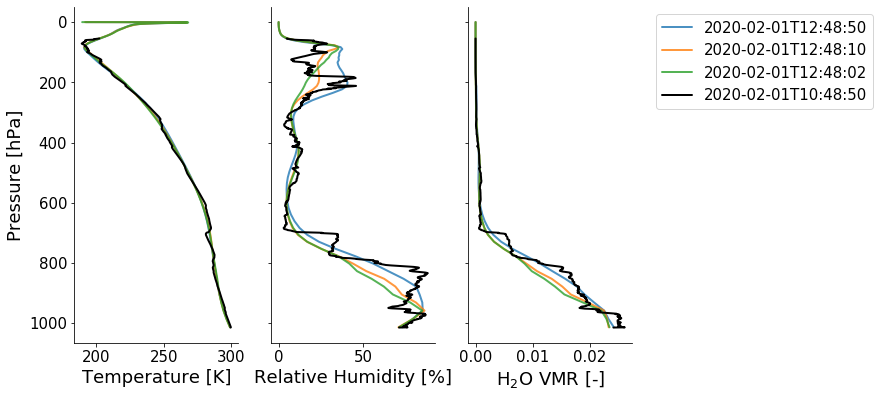

In [90]:
fig, axs = plot_collocated_profiles(collocations, alpha=0.8)
plot_radiosonde_profiles(radiosonde_data, fig=fig, axs=axs)
plt.savefig('plots/bco_radiosonde_iasi+retrieval_first_comparison.pdf')

In [119]:
collocations['Collocations/interval']

<xarray.DataArray 'Collocations/interval' (collocation: 31)>
array([ 4231000000000,  4231000000000,  4239000000000,  4239000000000,
        4255000000000,  4544000000000,  4560000000000,  4568000000000,
        4844000000000,  4852000000000,  4860000000000,  5099000000000,
        5107000000000,  6974000000000,  6974000000000,  6982000000000,
        6982000000000,  7301000000000,  7301000000000,  7309000000000,
        7309000000000,  8495000000000,  8503000000000, 10372000000000,
       10372000000000, 10380000000000, 10380000000000, 10703000000000,
       10703000000000, 10711000000000, 10711000000000],
      dtype='timedelta64[ns]')
Coordinates:
    iasi/lon     (collocation) float64 -58.55 -59.04 -58.43 ... -58.43 -58.5
    iasi/lat     (collocation) float64 12.6 12.73 13.07 ... 12.73 13.07 12.81
  * collocation  (collocation) int64 0 4 6 7 12 17 22 ... 87 88 89 94 96 98 99
Attributes:
    max_interval:  Max. interval in secs: 3:00:00
    max_distance:  Max. distance in kilometers: 100.0
    primary:       dropsondes
    secondary:     iasi

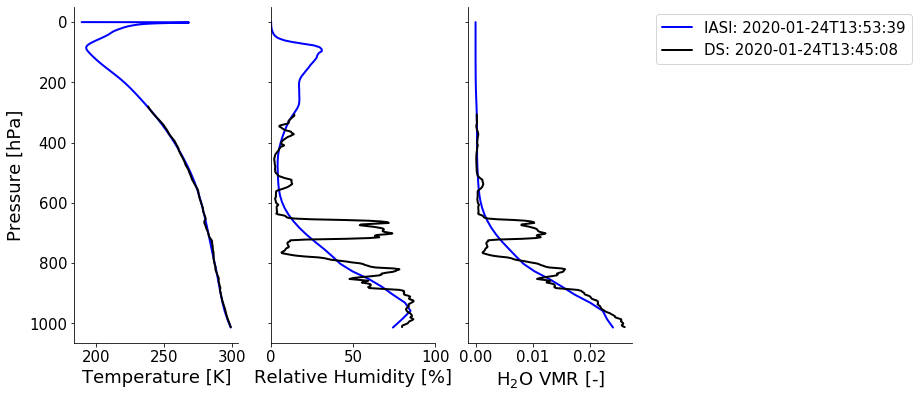

In [80]:
fig, axs = plot_collocated_iasi_profiles(collocations, 
                                         collocation_indices=np.arange(5, 6),#len(collocations.collocation)), 
                                         alpha=1.0)
fig, axs = plot_collocated_dropsonde_profiles(collocations, 
                                              collocation_indices=np.arange(5, 6),#len(collocations.collocation)), 
                                              fig=fig, axs=axs, alpha=1.0
                                             )

In [42]:
collocations['Collocations/distance'][5:6]

<xarray.DataArray 'Collocations/distance' (collocation: 1)>
array([14.45140272])
Coordinates:
    iasi/lon     (collocation) float64 -58.2
    iasi/lat     (collocation) float64 14.16
  * collocation  (collocation) int64 24
Attributes:
    max_interval:  Max. interval in secs: 0:10:00
    max_distance:  Max. distance in kilometers: 100.0
    primary:       dropsondes
    secondary:     iasi
    units:         kilometers

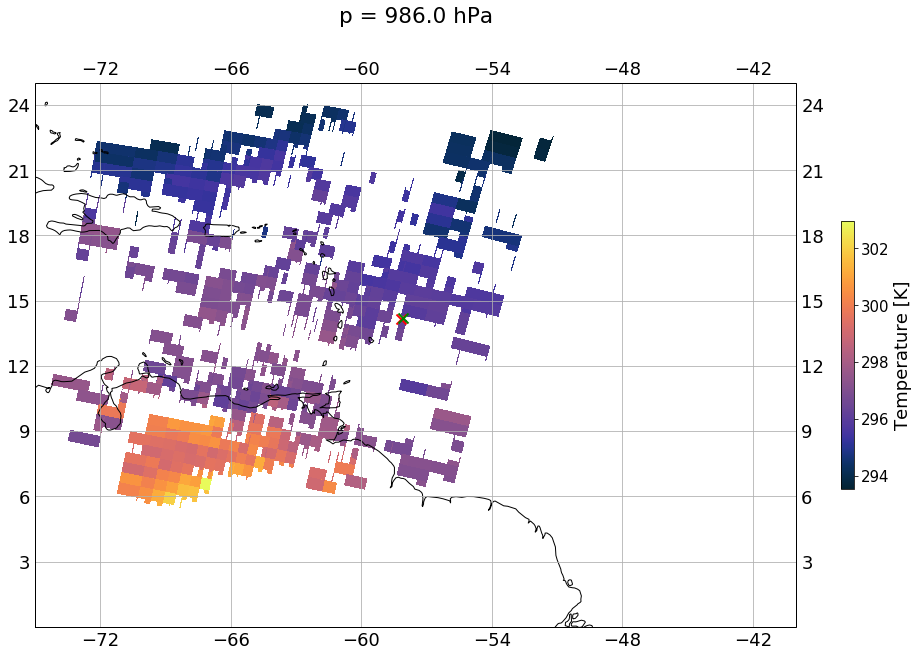

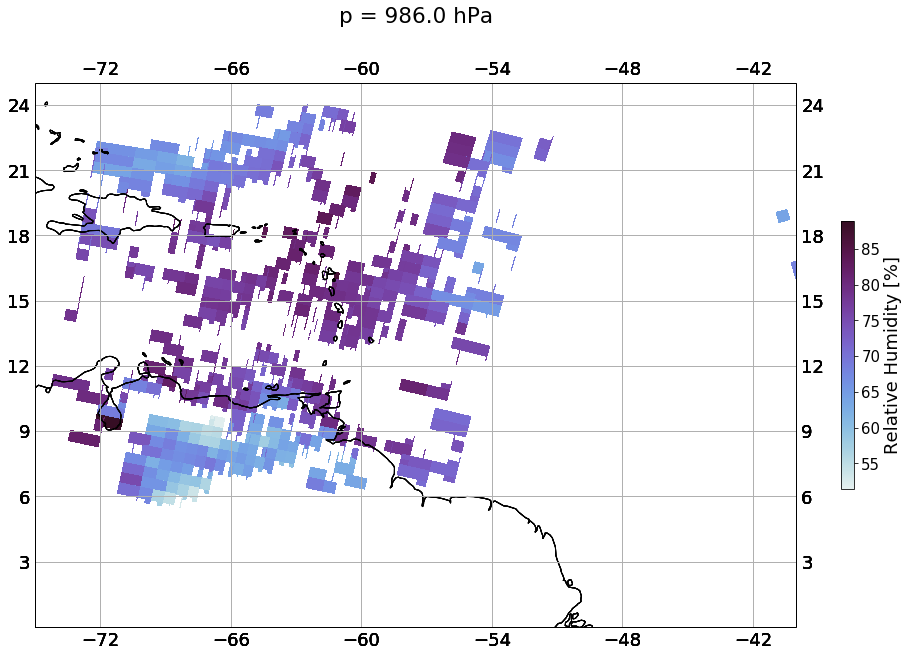

In [81]:
plot_temp_map([data_list[1]], 1000.)
worldmap(collocations['iasi/lat'][5:6], collocations['iasi/lon'][5:6], 
         marker='x', color='red', s=100)
worldmap(collocations['dropsondes/lat'][5:6], collocations['dropsondes/lon'][5:6], 
         marker='x', color='green', s=100)
# plt.savefig('plots/temp_map_2020_02_01.pdf')
plot_wv_map(data_list, 1000.)
# worldmap(collocations['dropsondes/lat'], collocations['dropsondes/lon'], 
#          marker='x', color='green', s=10)
# plt.savefig('plots/rh_map_2020_02_01.pdf')